# 🔥 _DeepFire_: API Project for Fire Detection 🔥

In this project, you'll apply your skills at neural network development in a new way: taking a model that you've trained yourself and deploying it to a static webpage that you can work with to upload new images and get prediction accuracy results. 

This project will primarily focus on your abilities in creating and testing neural network architecture development. 

#### **Specifically, you'll be creating a convolutional neural network that can ingest Fire Detection Image Data and predict binary class values, similarly to what we've done with multilayer perceptrons in the past.**

Boilerplate and supporting architectures have been provided for a multitude of tasks ranging from data preprocessing, processing, ingestion, and predictive assessment – however, major tasks and design work will ultimately be left to you to approach and figure out ideal, optimized solutions. 

#### 🔹 General Importations

As always, we'll start with importing basic tools and functions for our task.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import utils

import os, PIL
from glob import glob

import tensorflow as tf
tf.config.list_physical_devices()

print(tf.__version__)

2.6.0


2021-10-07 14:10:57.650844: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-10-07 14:10:57.705944: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-10-07 14:10:57.706720: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.


---

#### 🔎 Initializing Deep Learning Tools 🔍

---

> Your first task will be crucial to ensuring the successful implementation of the rest of your notebook. 
> 
> **Initialize each line with the correct function type from the TensorFlow documentation.**
> 
> Feel free to refer throughout the notebook and across previous notebooks to see which TensorFlow architectures you've used for similar tasks. 
> 
> To give you a guide for how this should look, you've been provided with a single correct function declaration in the form of `image_dataset_from_directory` at the end of the cell. 

---

In [2]:
""" Sequential Model Architecture """
Sequential = tf.keras.models.Sequential

""" Data Preprocessing Functions """
Resizing = tf.keras.layers.experimental.preprocessing.Resizing
Rescaling = tf.keras.layers.experimental.preprocessing.Rescaling

""" Data Augmentation Functions """
RandomFlip = tf.keras.layers.experimental.preprocessing.RandomFlip
RandomRotation = tf.keras.layers.experimental.preprocessing.RandomRotation
RandomZoom = tf.keras.layers.experimental.preprocessing.RandomZoom

""" Artificial Neural Network Layer Inventory """
Dense = tf.keras.layers.Dense
Dropout = tf.keras.layers.Dropout

""" Convolutional Neural Network Layer Inventory """
Conv2D = tf.keras.layers.Conv2D
MaxPool2D = tf.keras.layers.MaxPool2D
Flatten = tf.keras.layers.Flatten

""" Residual Network Layer Inventory """
ResNet50 = tf.keras.applications.ResNet50

""" Function to Load Images from Target Folder """
image_dataset_from_directory = tf.keras.preprocessing.image_dataset_from_directory

#### 🔹 Precheck Image Dataset Sizes

If you've followed instructions carefully from the `project/PROJECT.md` instructions, the following dataset directory instantiations should work perfectly. 

If they do not, double-check to make sure you've saved your dataset to the appropriate location. 

In [3]:
# Use the `glob.glob` function to show how many images are in each folder
DATA_DIRECTORY = "../dataset/"
FIRE_IMAGES_PATTERN = f"{DATA_DIRECTORY}/Fire_Images/*"
NOT_FIRE_IMAGES_PATTERN = f"{DATA_DIRECTORY}/Normal_Images/*"

print(f"Number of fire image samples: {len(glob(FIRE_IMAGES_PATTERN))}")
print(f"Number of non-fire image samples: {len(glob(NOT_FIRE_IMAGES_PATTERN))}")

Number of fire image samples: 541
Number of non-fire image samples: 541


#### 🔸 Load Dataset

Like we've done previously, let's set our batch size and image dimensions to work seamlessly with our configured model.

In [4]:
batch_size = 32
IMAGE_HEIGHT = IMAGE_WIDTH = 256

In [5]:
train = image_dataset_from_directory(
    directory=DATA_DIRECTORY,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=batch_size
)

Found 1082 files belonging to 2 classes.
Using 866 files for training.


2021-10-07 14:11:08.041770: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-07 14:11:08.044378: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-10-07 14:11:08.045041: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-10-07 14:11:08.045507: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built witho

In [6]:
class_names = train.class_names

In [7]:
validation = image_dataset_from_directory(
    directory=DATA_DIRECTORY,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=batch_size
)

Found 1082 files belonging to 2 classes.
Using 216 files for validation.


From these results, we can actually see that we have a major class imbalance with our fire images representing our minority class. 

Let's go ahead and fix that by resampling our dataset. 

#### 🔹 Resample (Oversample) Minority Class

In [8]:
def resample_class_distribution(train, DATA_DIRECTORY=DATA_DIRECTORY, save=True):
    """ Helper function to resample class distribution for image dataset. """
    minority_class, majority_class = list(), list()
    for images, labels, in train.take(3):
        for image, label in zip(images, labels):
            if label == 0:
                minority_class.append(image.numpy().astype(np.uint8))
            else:
                majority_class.append(image.numpy().astype(np.uint8))
    FIRE_SIZE = len(glob(f"{DATA_DIRECTORY}/Fire_Images/*"))
    NOT_FIRE_SIZE = len(glob(f"{DATA_DIRECTORY}/Normal_Images/*"))
    upsampled_images = np.array(utils.resample(minority_class, replace=True, 
                                               n_samples=(NOT_FIRE_SIZE - FIRE_SIZE),
                                               random_state=42))
    if save == True:
        index = 0
        for image in upsampled_images:
            PATH = f"{DATA_DIRECTORY}/Fire_Images/new_fire_{index}.png"
            PIL.Image.fromarray(image).save(PATH)
            index += 1

In [9]:
resample_class_distribution(train)

2021-10-07 11:56:30.607296: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


You should now see that additional images have been generated to balance out both classes prior to predictive modeling.

**Go ahead and re-run the `Load Dataset` steps to see new generated dataset changes.**

#### 🔹 Pre-Optimize Image File Ingestion

This is an accessory step to optimize image data ingestion at the cost of slightly higher memory usage. No modifications are required for this function. 

In [8]:
def configure_performant_datasets(dataset, shuffling=None):
    """ 
    Custom function to prefetch and cache stored elements
    of retrieved image data to boost latency and performance
    at the cost of higher memory usage. 
    """
    AUTOTUNE = tf.data.AUTOTUNE
    # Cache and prefetch elements of input data for boosted performance
    if not shuffling:
        return dataset.cache().prefetch(buffer_size=AUTOTUNE)
    else:
        return dataset.cache().shuffle(shuffling).prefetch(buffer_size=AUTOTUNE)

In [9]:
train =         configure_performant_datasets(train, shuffling=1000)
validation =    configure_performant_datasets(validation)

---

#### 🔎 Create Resizing and Normalization Layers 🔍

---

> For this task, you'll declare your resizing and normalization layers using the layer architectures that you imported earlier. 
>
> Recall that for this step, we want to accomplish two key tasks: 
> - Resize all images to the predetermined square image dimensions as indicated by `IMAGE_HEIGHT` and `IMAGE_WIDTH`.
> - Scale all images so pixel values are within the range of (0., 1.) rather than the original (0., 255.).
>
> Additionally, since we're working with colorized image data, we'll want to ensure that our image rescaling/normalization step inputs images as stacks-of-three, since each image channel corresponds to red, green, and blue pixel values. 
>
> As always, refer to previous notebook documentation on image normalization for colorization if you need help.

---

In [10]:
resizing_layer = Resizing(IMAGE_HEIGHT, IMAGE_WIDTH)
normalization_layer = Rescaling(1./255, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

---

#### 🔎 Neural Network Architecture Creation 🔍

---

> Now time for the main event! 
> 
> Here, you'll be creating and instantiating your model architecture. 
> 
> For this assignment, you'll be creating a **Convolutional Neural Network** that can process Fire Detection images for predictive purposes.
> 
> _For this project, you will not be provided guidance as to how to design and implement your CNN architecture._
> 
> Refer to previous notebooks and challenges on CNNs as well as online documentation/resources for how to design CNN models on higher-order images. 
> 
> **This is a highly creative step, and there are no wrong answers; however, you will be assessed on your experimentation process and why you choose specific modeling layers, configurations, optimizers, regularizers, and overall design choices.**
>
> Light boilerplate will be provided to get you started, but as always, use any and all resources at your disposal to finish the job! 

---

In [11]:
""" Sequential Model Architecture Setup """
model = Sequential()

""" CNN Layering Steps """
input_layer = tf.keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
flattening_layer = Flatten()
dropout_layer = Dropout(0.33)
conv2d_layer_1 = Conv2D(32, (3, 3), activation="relu")
conv2d_layer_2 = Conv2D(64, (3, 3), activation="relu")
conv2d_layer_3 = Conv2D(128, (3, 3), activation="relu")
pooling_layer_1, pooling_layer_2, pooling_layer_3 = MaxPool2D(), MaxPool2D(), MaxPool2D()
dense_layer_1 = Dense(128, activation="relu")
dense_layer_2 = Dense(64, activation="relu")
dense_layer_3 = Dense(32, activation="relu")
output_layer = Dense(1, activation="sigmoid")

augmentation_layer = Sequential(
    [
        input_layer,
        RandomFlip("horizontal_and_vertical"),
        RandomRotation(0.133),
        RandomZoom(0.133),
    ],
)

model.add(input_layer)

model.add(augmentation_layer)
model.add(resizing_layer)
model.add(normalization_layer)

model.add(conv2d_layer_1)
model.add(pooling_layer_1)
model.add(conv2d_layer_2)
model.add(pooling_layer_2)
model.add(conv2d_layer_3)
model.add(pooling_layer_3)

model.add(flattening_layer)

model.add(dense_layer_1)
model.add(dense_layer_2)
model.add(dropout_layer)
model.add(dense_layer_3)

model.add(output_layer)

""" CNN Architecture Summarization """
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 256, 256, 3)       0         
_________________________________________________________________
resizing (Resizing)          (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0

---

#### 🔎 Neural Network Configuration 🔍

---

> For this task, you'll compile your CNN architecture with appropriate parameters for loss calculation, optimization, and accuracy metrics.
> 
> As always, refer to previous notebooks, tutorials, and documentation for best-case parameters to use for image recognition models.

---

In [12]:
""" CNN Model Compilation """
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer="sgd",
    metrics=["accuracy"],
)

---

#### 🔎 CNN Model Predictive Fitness 🔍

---

> For this task, you'll be taking your compiled model and fitting it against your training and validation data.
> 
> Keep in mind that there are several opportunities for further optimizing your workflow with techniques such as batch normalization, generator-based data feeding, etc. 
> 
> As always, refer to previous notebooks, tutorials, and documentation for designing model fitness with validation data. 

---

In [13]:
""" CNN Model Fitness and History Extraction """
epochs = 1000
history = model.fit(
    train,
    validation_data=validation,
    epochs=epochs,
)

Epoch 1/1000


2021-10-07 14:11:34.885128: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-07 14:11:36.606809: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204
2021-10-07 14:11:37.752246: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-10-07 14:11:38.891813: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


28/28 [==============================] - 7s 55ms/step - loss: 0.6685 - accuracy: 0.6640 - val_loss: 0.6091 - val_accuracy: 0.7361
Epoch 2/1000
28/28 [==============================] - 1s 28ms/step - loss: 0.5615 - accuracy: 0.7564 - val_loss: 0.5240 - val_accuracy: 0.7500
Epoch 3/1000
28/28 [==============================] - 1s 28ms/step - loss: 0.4992 - accuracy: 0.7771 - val_loss: 0.4888 - val_accuracy: 0.7870
Epoch 4/1000
28/28 [==============================] - 1s 28ms/step - loss: 0.4791 - accuracy: 0.7852 - val_loss: 0.4875 - val_accuracy: 0.7870
Epoch 5/1000
28/28 [==============================] - 1s 28ms/step - loss: 0.4599 - accuracy: 0.7968 - val_loss: 0.4260 - val_accuracy: 0.8148
Epoch 6/1000
28/28 [==============================] - 1s 28ms/step - loss: 0.4620 - accuracy: 0.7910 - val_loss: 0.3851 - val_accuracy: 0.8009
Epoch 7/1000
28/28 [==============================] - 1s 28ms/step - loss: 0.4205 - accuracy: 0.8164 - val_loss: 0.3543 - val_accuracy: 0.8287
Epoch 8/1000

---

#### 🔎 CNN Model Evaluation 🔍

---

> For this task, you'll evaluate your CNN model using the validation dataset in order to calculate overall validation accuracy and loss.
> 
> As always, refer to previous notebooks, tutorials, and documentation for using the proper evaluation function for model prediction. 

---

7/7 [==============================] - 0s 9ms/step - loss: 0.3108 - accuracy: 0.9630


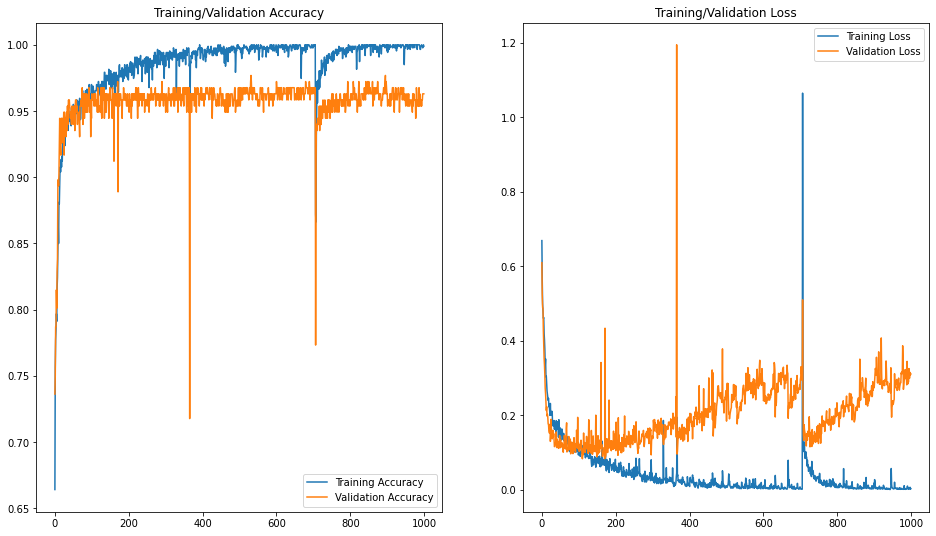

In [14]:
""" CNN Model Predictive Evaluation """
model.evaluate(validation)

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(16, 9))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training/Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training/Validation Loss")

plt.show()

#### 🔹 Model State Saving

When you are satisfied with your model state configuration and performance and are ready to export the model's weights and parameters for deployment purposes, simply run the following function! 

In [15]:
def save_model(model, file_name, save_format):
    """ 
    Save the model weights and architecture.
    
    Parameters: 
       model(Model): keras Model object being saved
       file_name(str): name of the Hadoop file where
                       the whole model will be saved
       save_format(str): Indicates whether to save the model to the default
                         SavedModel('tf'), or HDF5('h5'), or 
                         use both H5 and JSON ('composite') formats. 
       Returns: None
    """
    MODEL_DIRECTORY = "../model"
    def __save_as_composite():
      """ Saving the model as H5 (for params) + JSON (for the architecture) """
      # Save the weights
      model.save_weights(f'{MODEL_DIRECTORY}/{file_name}_params.h5')
      # Save the architecture
      with open(f'{MODEL_DIRECTORY}/{file_name}_layers.json', 'w') as f:
          f.write(model.to_json())
    
    def __save_as_h5():
      """ Option 2: Saving whole model as a single H5 file (more storage) """
      model.save(f"{MODEL_DIRECTORY}/{file_name}.h5", save_format=save_format)

    # Call the appropiate save func
    if save_format == 'h5':
      __save_as_h5()
    elif save_format == 'composite':
      __save_as_composite()
    else:  # save as a SavedModel
      model.save(file_name)

In [16]:
save_model(model, "fire_cnn_classifier", "composite")

Now go ahead and complete the remaining tasks in `project/PROJECT.md` to complete this project successfully! 

---
---
---